In [1]:
from core import *
import matplotlib.pyplot as plt

# Making a single/basic model ring

In [2]:
a = 51149 #km
e = 0.5
i = 80.0
omega = 60.0
w = 30.
imsize = 300 #px
pixscale = 500 #km/px

In [3]:
ringmodel = Ring(a, e, omega, i, w)
img = ringmodel.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)

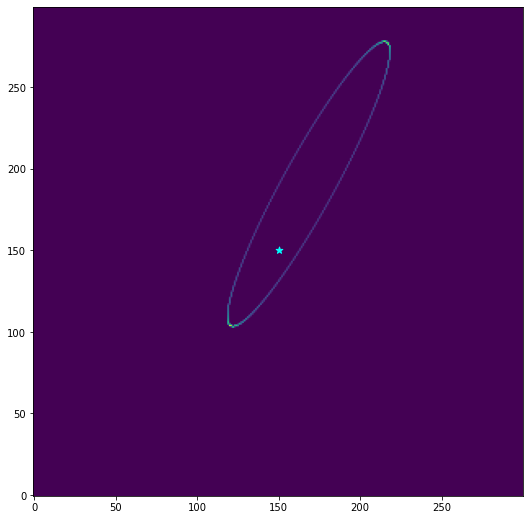

In [4]:
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

this is still wrong. try changing omega from 0 to 90 with i = 0, w = 0, e = 0.5. shouldn't this have no effect whatsoever? and yet it does have an effect?

## giving rings width and brightness

of course, real rings are not infinitesimal mathematical constructs. they have width, and in an astronomical context, they also have surface brightness. Note here that we can also modify the ring properties in place, but we must specify Astropy units when doing so.

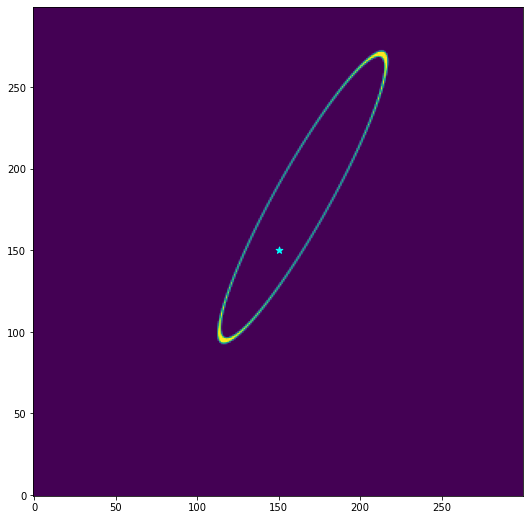

In [5]:
# to do: add a colorbar here!
ringmodel2 = Ring(a, 0.01, omega, i, w, flux = 0.001, width = 500)
ringmodel2.e = 0.4
ringmodel2.width = 2000*u.km
img = ringmodel2.as_2d_array((imsize, imsize), pixscale) #shape (pixels), pixscale (km)
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

## using ring objects as masks

suppose we wanted to extract the flux from a real image in an annulus defined by the ring above. this is easily done, because under the hood, these rings are photutils.EllipticalAnnulus objects. We can simply say,

In [6]:
ann = ringmodel2.as_elliptical_annulus((imsize, imsize), pixscale)
print(type(ann))

<class 'photutils.aperture.ellipse.EllipticalAnnulus'>


## convolving with a beam

we can also define an elliptical beam to convolve with as we cast into a 2-D array

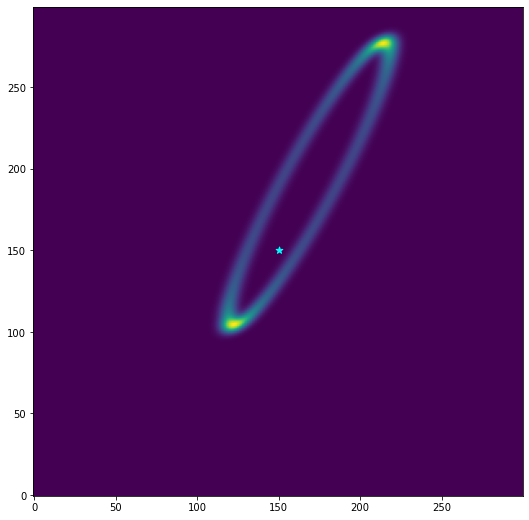

In [7]:
img = ringmodel.as_2d_array((imsize, imsize), pixscale, beamsize = (10,6,30*u.degree))

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(img, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.savefig('example_epsilon_ring.png')
plt.show()

# Model ring system observation

the RingSystemModelObservation tool makes mock observations of rings. It contains a static data table of ring properties for Jupiter, Saturn, Uranus, and Neptune. It interfaces with the Planetary Ring Node query tool and the JPL Horizons query tool to make the proper projected geometry for a given time of observation. The end result is basically a fully-editable Python version of the Planetary Ring Node.  Here is an example of a simple query:

In [8]:
epoch = '2020-01-30 00:00'
alma_coords = (-23.029 * u.deg, -67.755 * u.deg, 5000 * u.m) #lat, lon, alt(m)
ringnames = ['Six', 'Five', 'Four', 'Alpha', 'Beta', 'Eta', 'Gamma', 'Delta', 'Epsilon']

In [9]:
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = ringnames)
print(uranus_rings.rings['Epsilon'])

Ring instance; a=51149.0 km, e=0.00794, i=45.54283 deg, width=58.1 km


The model observation has made Ring objects for each ring in ringnames. All the properties of Ring objects discussed above can be used here. Let's go ahead and plot the full model

In [11]:
pixscale = 300*u.km
imsize = 500

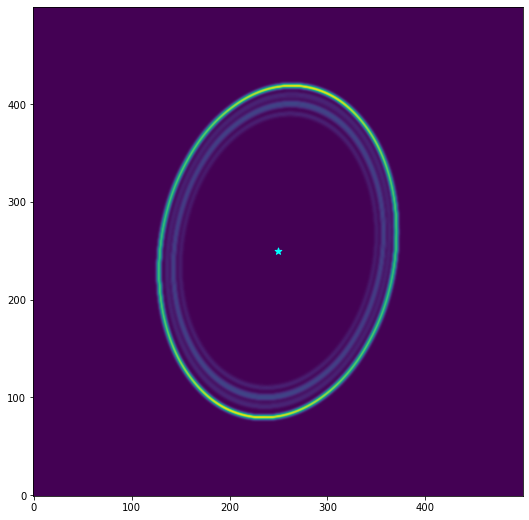

In [12]:
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (4,4,30*u.degree)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

Notice that we do not need to specify an image size or pixel scale until we have decided to cast the system into an array. This gives us more flexibility to modify things before plotting or comparing to observations

## modifying the defaults

sometimes we want something other than the default values for radius, eccentricity, etc., or to play with different ephemerides. In this case, we can simply modify the Ring objects directly before plotting.  Let's make the epsilon ring larger, and the alpha ring more eccentric

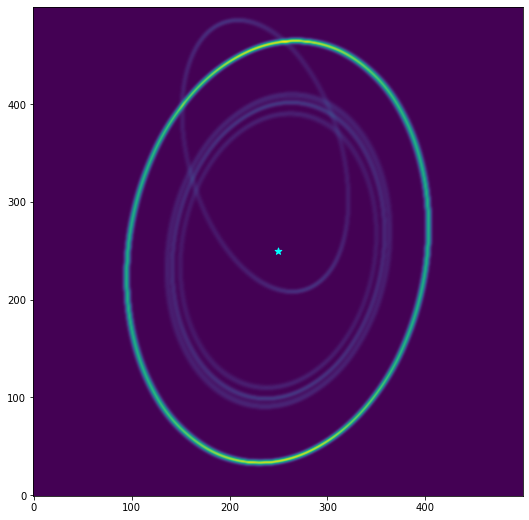

In [13]:
uranus_rings.rings['Epsilon'].a = 65000*u.km
uranus_rings.rings['Alpha'].e = 0.7
uranus_rings.rings['Alpha'].omega = 120*u.deg
obs = uranus_rings.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30*u.degree)) 
fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## support for minor rings

The static data tables loaded from the PDS support minor rings and dusty rings, too.

Ring instance; a=39600.0 km, e=0.0, i=45.54283 deg, width=3500.0 km


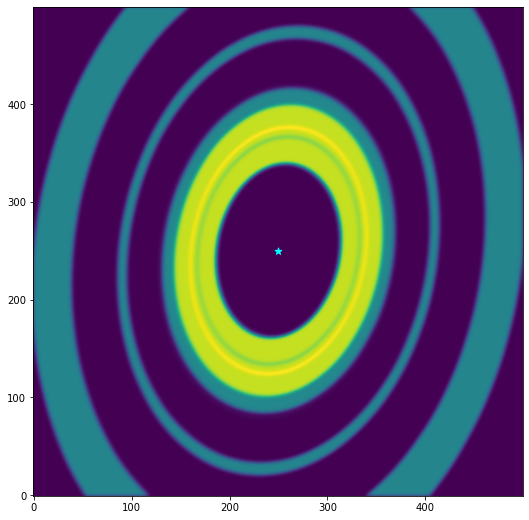

In [14]:
epoch_astropy = Time(epoch, format = 'iso', scale = 'utc')
alma_coords_astropy = EarthLocation(alma_coords[0], alma_coords[1], alma_coords[2])
    
uranus_rings_dusty = RingSystemModelObservation('uranus',
                     epoch=epoch_astropy,
                     location = alma_coords_astropy,
                     ringnames = None)

print(uranus_rings_dusty.rings['Zeta'])

obs = uranus_rings_dusty.as_2d_array((imsize, imsize), pixscale, beamsize = (5,4,30*u.degree)) 

fig, ax = plt.subplots(1,1, figsize = (9,9))

ax.imshow(obs, origin = 'lower')
ax.scatter([imsize/2],[imsize/2], color = 'cyan', marker = '*', s = 50, label = 'center of Uranus')
plt.show() 

## modifying widths and fluxes

This image shows some weaknesses of the default behavior: for minor rings, the relative brightnesses and/or widths are very often incorrect due to a lack of good data. We can get around this either by modifying each Ring object after instantiating them, or by inputting a list of fluxes and/or widths as we instantiate the model, as shown here:

# Making a movie of the epsilon ring precession

idea: run many queries to ring node tool, use the resulting arguments of periapsis to modify just the epsilon ring each time we plot. make a note that we could do this just as well by making repeated calls to RingSystemModelObservation, but that would be slower. Might want to bump the eccentricity of the epsilon ring up a bit to make it look good.

In [15]:
from datetime import datetime, timedelta
node = RingNode()
epoch_0 = ''
for i in range(3): #eventually get to 100
    
    epoch = 
    bodytable, ringtable = node.ephemeris(planet=planet, epoch=epoch, location=location, cache=False)
    ringtable['Epsilon']

SyntaxError: invalid syntax (3876977062.py, line 6)